# Definition of the model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from constants import *
import datasets
from visualization import *
import time
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [2]:
class BeatTracker(nn.Module):
    
    def __init__(self, hidden_size=256, num_layers=3):
        super(BeatTracker, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
                        nb, 
                        hidden_size, 
                        num_layers, 
                        bidirectional=True, 
                        dropout=0.2,
                        batch_first=True)
        self.hid_to_beat = nn.Linear(2 * hidden_size, 2)
        self.hidden = None
        
        self.loss_function = nn.NLLLoss()
        
        self.lr = 0.001
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5)

    def forward(self, spec):
        x = self.lstm(spec)[0]
        x = self.hid_to_beat(x)
        x = F.log_softmax(x, dim=-1)
        return x
    
    def set_lr(self, lr):
        self.lr = lr
        for p in self.optimizer.param_groups:
            p['lr'] = lr
    
    def loss(self, spec, onsets, isbeat):
        output = self(spec)
        output = output[onsets == 1]
        target = isbeat[onsets == 1]
        loss = self.loss_function(output, target)
        return loss

    def loss_from_dataset(self, dataset, batch_size=32):
        dataloader = DataLoader(dataset, batch_size=batch_size)
        loss = 0
        with torch.no_grad():
            loss = 0
            for specs, onsets, isbeat in dataloader:
                loss += self.loss(specs, onsets, isbeat).item()
            loss /= len(dataloader)
        return loss
    
    def learn(self, spec, onsets, isbeat):
        self.optimizer.zero_grad()
        output = self(spec)
        output = output[onsets == 1]
        target = isbeat[onsets == 1]
        loss = self.loss_function(output, target)
        loss.backward()
        self.optimizer.step()
        
        predic = torch.argmax(output, dim=1)
        accuracy = torch.sum(predic == target).item() / predic.shape.numel()
        
        return loss.item(), accuracy
    
    def fit(self, dataset, validset, batch_size=1, epochs=1):
        len_dataloader = -(-len(dataset) // batch_size)  # quick ceiling function
        loss_hist = np.zeros((epochs, len_dataloader))
        accu_hist = np.zeros((epochs, len_dataloader))
        valid_hist= np.zeros(epochs)
        for e in range(epochs):
            start = time.time()
            
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, (spec, onsets, isbeat) in enumerate(dataloader):
                loss, accuracy = self.learn(spec, onsets, isbeat)
                loss_hist[e, i] = loss
                accu_hist[e, i] = accuracy
            
            valid_hist[e] = self.loss_from_dataset(validset)
            
            end = time.time()
            t = end - start
            eta = str(datetime.timedelta(seconds=int(t * (epochs - e - 1))))
            print(f'| Epoch: {e + 1:{len(str(epochs))}} | ', end='')
            print(f'Loss: {np.mean(loss_hist[e]):7.4f} | ', end='')
            print(f'Valid loss: {valid_hist[e]:7.4f} | ', end='')
            print(f'Accuracy: {np.mean(accu_hist[e]):5.4f} | ', end='')
            print(f'{t / len(dataloader):.2f} s/b | Eta: {eta} |')
        return loss_hist, accu_hist, valid_hist
    
    def predict(self, specs, onsets):
        """So far only works if batch_size = 1"""
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            pred_t = torch.argmax(output, dim=1)
            onsets_frames = np.argwhere(onsets.squeeze(0) == 1).squeeze(0)
            beats_frames = onsets_frames[pred_t == 1]
            pred = torch.zeros_like(onsets)
            pred[:, beats_frames] = 1
        return pred
    
    def evaluate(self, specs, onsets, isbeat):
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            target = isbeat[onsets == 1]
            predic = torch.argmax(output, dim=1)
            
            tn = torch.sum((predic == 0) & (target == 0)).item()
            fp = torch.sum((predic == 1) & (target == 0)).item()
            fn = torch.sum((predic == 0) & (target == 1)).item()
            tp = torch.sum((predic == 1) & (target == 1)).item()
        return tn, fp, fn, tp
    
    def evaluate_from_dataset(self, dataset, batch_size=16):
        dataloader = DataLoader(dataset, batch_size=batch_size)
        ttn = 0
        tfp = 0
        tfn = 0
        ttp = 0
        for specs, onsets, isbeat in dataloader:
            tn, fp, fn, tp = self.evaluate(specs, onsets, isbeat)
            ttn += tn
            tfp += fp
            tfn += fn
            ttp += tp
        return ttn, tfp, tfn, ttp
    
    def freeze(self):
        for p in self.parameters():
            p.requires_grad = False
            
    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad = True

class ToTensor(object):
    
    def __call__(self, sample):
        spec_np, onsets_np, isbeat_np = sample
        
        # Normalize to [-1, 1]
        spec_np = 2 * (spec_np - spec_np.min()) / (spec_np.max() - spec_np.min()) - 1
        spec = torch.tensor(spec_np.T, dtype=torch.float, device=device)
        
        onsets = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        isbeat = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        
        onsets[onsets_np] = 1
        isbeat[onsets_np[isbeat_np == 1]] = 1
        
        return spec, onsets, isbeat

totensor = ToTensor()
    
def beat_track(isbeat):
    onset_envelope = isbeat.squeeze(0).numpy()
    tempo, bt = librosa.beat.beat_track(
                            sr=sr, 
                            onset_envelope=onset_envelope, 
                            hop_length=hl, 
                            tightness=800)
    return bt

# Datasets

Take a subset of the GTZAN dataset preprocessed using `preprocess-GTZAN` and split it into a train set and a validation set.

In [3]:
dataset = datasets.GTZAN()

Or also the BALLROOM dataset

In [4]:
dataset = datasets.BALLROOM()

Visualize an example.

In [4]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
spec, onsets, isbeat = dataset[i]
beats = dataset.get_beats(i)

2699/3000


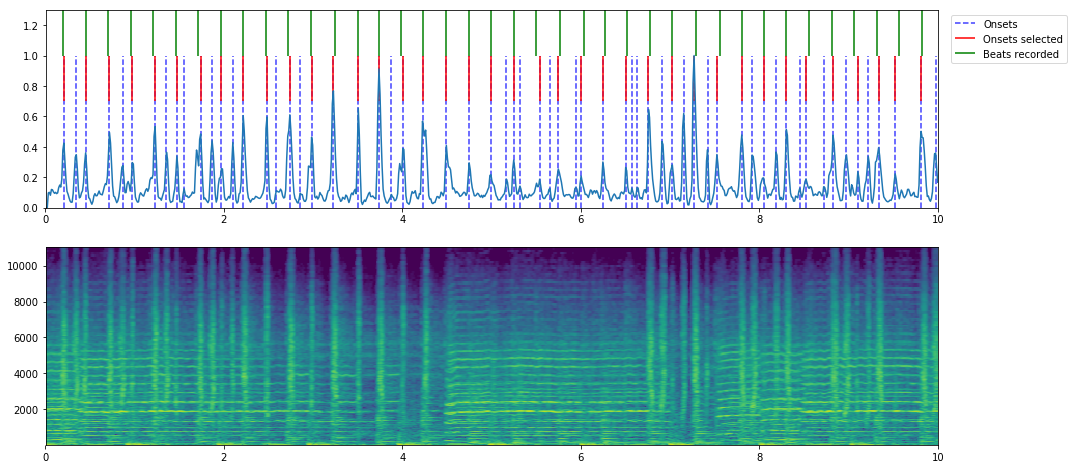

In [5]:
showdata(spec, onsets, isbeat, beats)

# Make training and validation sets

In [3]:
gtzan = datasets.GTZAN(transform=totensor)
ballroom = datasets.BALLROOM(transform=totensor)
dataset = gtzan + ballroom

In [4]:
p = 0.8
train_size = int(p * len(dataset))
indices = list(np.random.permutation(len(dataset)))
trainset = Subset(dataset, indices[:train_size])
validset = Subset(dataset, indices[train_size:])

print(f'Full set size: {len(dataset)}')
print(f'   Train size: {len(trainset)}')
print(f'   Valid size: {len(validset)}')

Full set size: 5094
   Train size: 4075
   Valid size: 1019


# Find learning rate

In [5]:
model = BeatTracker()
model.to(device)

BeatTracker(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

Make an array of learning rates.

In [15]:
dataloader = DataLoader(trainset, batch_size=32, shuffle=True)
n_mb = len(dataloader) # number of mini batches
print(f'{n_mb} mini batches')
lr = (10. ** -np.arange(0, 5, 5 / n_mb))[::-1]

128 mini batches


Then find lr

In [16]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    print(f'{i + 1}/{n_mb}')
    model.set_lr(lr[i])
    loss, accuracy = model.learn(specs, onsets, isbeat)
    losses[i] = loss

1/128
2/128
3/128
4/128
5/128
6/128
7/128
8/128
9/128
10/128
11/128
12/128
13/128
14/128
15/128
16/128
17/128
18/128
19/128
20/128
21/128
22/128
23/128
24/128
25/128
26/128
27/128
28/128
29/128
30/128
31/128
32/128
33/128
34/128
35/128
36/128
37/128
38/128
39/128
40/128
41/128
42/128
43/128
44/128
45/128
46/128
47/128
48/128
49/128
50/128
51/128
52/128
53/128
54/128
55/128
56/128
57/128
58/128
59/128
60/128
61/128
62/128
63/128
64/128
65/128
66/128
67/128
68/128
69/128
70/128
71/128
72/128
73/128
74/128
75/128
76/128
77/128
78/128
79/128
80/128
81/128
82/128
83/128
84/128
85/128
86/128
87/128
88/128
89/128
90/128
91/128
92/128
93/128
94/128
95/128
96/128
97/128
98/128
99/128
100/128
101/128
102/128
103/128
104/128
105/128
106/128
107/128
108/128
109/128
110/128
111/128
112/128
113/128
114/128
115/128
116/128
117/128
118/128
119/128
120/128
121/128
122/128
123/128
124/128
125/128
126/128
127/128
128/128


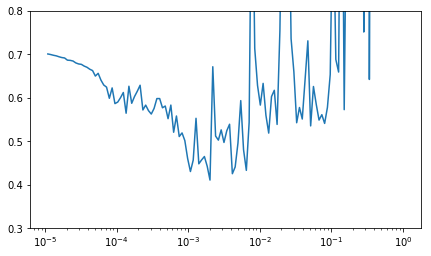

In [17]:
plt.figure(figsize=(7, 4))
plt.ylim(0.3, 0.8)
plt.semilogx(lr, losses);

Something like `lr=0.0005` seems like a good fit.

# Training of the model

In [6]:
model = BeatTracker()
model.to(device)
model.set_lr(0.0001)
print_params(model)
model.eval()
model.freeze()

 ----------------------------------------------------------
| lstm.weight_ih_l0            | [1024, 256]  |    262,144 |
| lstm.weight_hh_l0            | [1024, 256]  |    262,144 |
| lstm.bias_ih_l0              | [1024]       |      1,024 |
| lstm.bias_hh_l0              | [1024]       |      1,024 |
| lstm.weight_ih_l0_reverse    | [1024, 256]  |    262,144 |
| lstm.weight_hh_l0_reverse    | [1024, 256]  |    262,144 |
| lstm.bias_ih_l0_reverse      | [1024]       |      1,024 |
| lstm.bias_hh_l0_reverse      | [1024]       |      1,024 |
| lstm.weight_ih_l1            | [1024, 512]  |    524,288 |
| lstm.weight_hh_l1            | [1024, 256]  |    262,144 |
| lstm.bias_ih_l1              | [1024]       |      1,024 |
| lstm.bias_hh_l1              | [1024]       |      1,024 |
| lstm.weight_ih_l1_reverse    | [1024, 512]  |    524,288 |
| lstm.weight_hh_l1_reverse    | [1024, 256]  |    262,144 |
| lstm.bias_ih_l1_reverse      | [1024]       |      1,024 |
| lstm.bias_hh_l1_reverse

Evaluate

In [7]:
confusion(*model.evaluate_from_dataset(validset))

 -----------------------
| tp: 19574 | fp: 48209 |
| fn:     0 | tn:     0 |
 -----------------------
Precision: 0.2888
   Recall: 1.0000
 Accuracy: 0.2888


In [70]:
confusion(*model.evaluate_from_dataset(trainset))

 -------------------------
| tp:    192 | fp:    931 |
| fn:  78596 | tn: 190825 |
 -------------------------
Precision: 0.1710
   Recall: 0.0024
 Accuracy: 0.7060


Train

In [8]:
model.unfreeze()
model.train();

In [9]:
lost_hist, accu_hist, valid_hist = model.fit(trainset, validset, batch_size=32, epochs=30)

| Epoch:  1 | Loss:  0.4968 | Valid loss:  0.3692 | Accuracy: 0.7609 | 0.94 s/b | Eta: 0:58:11 |
| Epoch:  2 | Loss:  0.3337 | Valid loss:  0.3153 | Accuracy: 0.8582 | 0.69 s/b | Eta: 0:41:10 |
| Epoch:  3 | Loss:  0.3115 | Valid loss:  0.3247 | Accuracy: 0.8693 | 0.69 s/b | Eta: 0:39:42 |
| Epoch:  4 | Loss:  0.2987 | Valid loss:  0.2922 | Accuracy: 0.8756 | 0.68 s/b | Eta: 0:37:59 |
| Epoch:  5 | Loss:  0.2869 | Valid loss:  0.2894 | Accuracy: 0.8802 | 0.69 s/b | Eta: 0:36:36 |
| Epoch:  6 | Loss:  0.2745 | Valid loss:  0.2920 | Accuracy: 0.8867 | 0.69 s/b | Eta: 0:35:08 |
| Epoch:  7 | Loss:  0.2783 | Valid loss:  0.2745 | Accuracy: 0.8861 | 0.68 s/b | Eta: 0:33:35 |
| Epoch:  8 | Loss:  0.2587 | Valid loss:  0.2676 | Accuracy: 0.8947 | 0.68 s/b | Eta: 0:32:06 |
| Epoch:  9 | Loss:  0.2532 | Valid loss:  0.2736 | Accuracy: 0.8968 | 0.69 s/b | Eta: 0:30:43 |
| Epoch: 10 | Loss:  0.2461 | Valid loss:  0.2560 | Accuracy: 0.9010 | 0.70 s/b | Eta: 0:30:00 |
| Epoch: 11 | Loss:  0.2590 | 

In [10]:
torch.save(model.state_dict(), './data/model_07.pt')

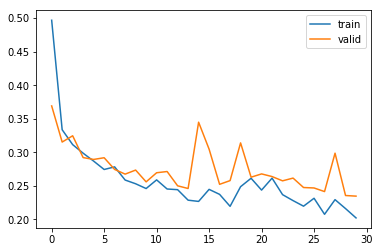

In [11]:
plt.plot(np.mean(lost_hist, axis=1), label='train')
plt.plot(valid_hist, label='valid')
plt.legend();

In [12]:
np.save('./data/lost_hist_07.npy', lost_hist)

In [13]:
np.save('./data/accu_hist_07.npy', accu_hist)

In [14]:
np.save('./data/valid_hist_07.npy', valid_hist)

Reevaluate

In [16]:
model.eval()
model.freeze()

In [17]:
confusion(*model.evaluate_from_dataset(validset))

 -----------------------
| tp: 15499 | fp:  2099 |
| fn:  4075 | tn: 46110 |
 -----------------------
Precision: 0.8807
   Recall: 0.7918
 Accuracy: 0.9089


In [18]:
confusion(*model.evaluate_from_dataset(trainset))

 -------------------------
| tp:  65112 | fp:   6469 |
| fn:  13480 | tn: 184613 |
 -------------------------
Precision: 0.9096
   Recall: 0.8285
 Accuracy: 0.9260


# Test

In [19]:
from IPython.display import Audio

def unibatch(spec_np, onsets_np, isbeat_np):
    """ Get a minibatch of one sample from the original numpy data."""
    spec, onsets, isbeat = totensor((spec_np, onsets_np, isbeat_np))
    spec = spec.unsqueeze(0)
    onsets = onsets.unsqueeze(0)
    isbeat = isbeat.unsqueeze(0)
    return spec, onsets, isbeat

Load the pretrained model and freeze its parameters.

In [ ]:
# model = BeatTracker()
# model.load_state_dict(torch.load('./data/model_03.pt', map_location=device))
# model.eval()
# model.freeze()

Take a dataset

In [27]:
dataset = datasets.GTZAN()

Take a random sample

In [28]:
i = np.random.randint(len(dataset))
spec_np, onsets_np, isbeat_np = dataset[i]
beats_np = dataset.get_beats(i)

Compute the beat track from the RNN algorithm and compare with librosa and ground truth.

In [29]:
# RNN
spec, onsets, isbeat = unibatch(spec_np, onsets_np, isbeat_np)
pred = model.predict(spec, onsets)
bt = beat_track(pred)
bt_times = librosa.frames_to_time(bt, sr, hl)

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# Librosa
onset_envelope = librosa.onset.onset_strength(S=spec_np)
tempo, bt_lib  = librosa.beat.beat_track(onset_envelope=onset_envelope)
bt_lib_times   = librosa.frames_to_time(bt_lib, sr, hl)

In [ ]:
plt.figure(figsize=(16, 2))
plt.vlines(bt_lib_times, 2, 3, color='b', label='Librosa')
plt.vlines(beats_np, 1, 2, color='g', label='Ground truth')
plt.vlines(bt_times, 0, 1, color='r', label='RNN')
plt.xlim(0, 10)
plt.ylim(0, 3)
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1));

Listen to the three different beat tracks.

In [ ]:
wav = dataset.get_wav(i)
Audio(wav, rate=sr)

In [ ]:
# RNN
click = librosa.clicks(bt_times, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [ ]:
# Librosa
click = librosa.clicks(bt_lib_times, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [ ]:
# Ground truth (sort of)
click = librosa.clicks(beats_np, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)